In [53]:
import spacy

nlp: dict[str, spacy.Language] = {}

nlp["en"] = spacy.load("en_core_web_sm")
nlp["en"].max_length = 2000000

sources = {
    #"en": "../data/moby_dick.txt",
    "en": "../data/pride_and_prejudice.txt",
}

sources_data = {}
for language in sources:
    file = open(sources[language], 'r')
    contents = file.read()
    sources_data[language] = contents


In [54]:
def tokenizer(text: str, model_lang: spacy.Language) -> list[str]:
    doc = model_lang(text)
    tokens = [token.text for token in doc if not token.is_space and not token.is_punct and not token.is_digit]
    return tokens

def tokens(sources_data: dict[str, str]) -> dict[str, list[str]]:
    tokenized_sources = {}
    for language in sources_data:
      tokenized_sources[language] = tokenizer(sources_data[language], nlp[language])
    return tokenized_sources

tokenized_sources = tokens(sources_data)

Shuffled >= Normal: 0/24
right p-value: 0.0


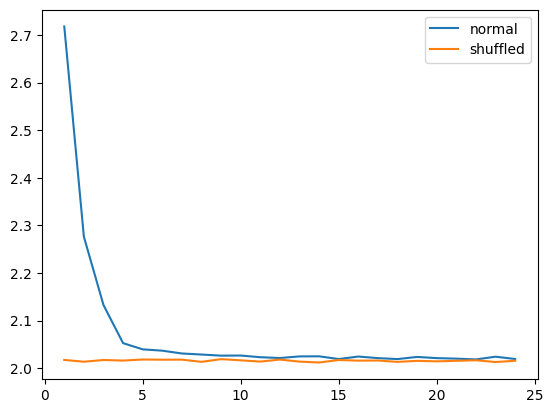

In [59]:
import math
import matplotlib.pyplot as plt
import time
import numpy
import random

def process_data_d(data: list[str], d: int) -> dict[str, dict[str, int]]:
    # dict of token x -> token y -> f(x,y)
    processed_data: dict[str, dict[str, int]] = {}
    data_length = len(data)
    for i in range(data_length):
        token_data = processed_data.get(data[i], {})
        # TODO: should x == y be excluded?
        if i+d < data_length: # and data[i] != data[i+d]:
            # add 1 to the frequency of the token y that appears d tokens after the current token x
            token_data[data[i+d]] = token_data.get(data[i+d], 0) + 1
        elif i+d >= data_length:
            break
        processed_data[data[i]] = token_data
    return processed_data

def calculate_I_d(data: dict[str, dict[str, int]]) -> float:
    # calculate f(x|d) and f(y|d) and F
    f_x_d: dict[str, int] = {}
    f_y_d: dict[str, int] = {}
    F = 0
    for token_x in data:
        f_x_d[token_x] = 0
        for token_y in data[token_x]:
            f_y_d[token_y] = f_y_d.get(token_y, 0) + data[token_x][token_y]
            f_x_d[token_x] += data[token_x][token_y]
            F += data[token_x][token_y]

    # calculate I(d)
    I_d = 0
    for token_x in data:
        for token_y in data[token_x]:
            p_x_y = data[token_x][token_y]/F
            p_x_d = f_x_d[token_x]/F
            p_y_d = f_y_d[token_y]/F
            # sum p(x,y|d)*log(p(x,y|d)/(p(x|d)*p(y|d))) for each x and y
            I_d += p_x_y * math.log(p_x_y/(p_x_d * p_y_d))
    return I_d



for language in tokenized_sources:
    I_d: dict[int, float] = {}
    I_d_shuffled: dict[int, float] = {}
    x = []
    y = []
    y_shuffled = []
    total = 0
    shuffled_geq_normal = 0
    start = time.time()

    shuffled_data = tokenized_sources[language].copy()
    random.shuffle(shuffled_data)
    numpy.random.shuffle(shuffled_data)

    d_max = 25

    for d in range(1, d_max):
        # if d%200 != 0:
        #     continue
        
        data_d = process_data_d(tokenized_sources[language], d)
        I_d[d] = calculate_I_d(data_d)

        data_shuffled = process_data_d(shuffled_data, d)
        I_d_shuffled[d] = calculate_I_d(data_shuffled)

        total += 1
        if I_d_shuffled[d] >= I_d[d]:
            shuffled_geq_normal += 1

        x.append(d)
        y.append(I_d[d])
        y_shuffled.append(I_d_shuffled[d])

        if d%10000 == 0 and d != 0:
            end = time.time()
            print(f"Progress: {d}/{len(tokenized_sources[language])-1} (elapsed time: {end - start})")
            start = time.time()
    
    print(f"Shuffled >= Normal: {shuffled_geq_normal}/{total}")
    # the right p-value is the proportion of times the shuffled I(d) is greater than or equal to the normal I(d)
    print(f"right p-value: {shuffled_geq_normal/total}")

    plt.plot(x, y, label="normal")
    plt.plot(x, y_shuffled, label="shuffled")
    plt.legend()
    plt.show()
